In [ ]:
# !pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 30.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=1d8e86e9ca2c016656f8727c52c8439d97e84a7a43753ca91e7d243373708229
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import random
#from torch_geometric.utils import to_networkx
import networkx as nx
import itertools
import tqdm
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.data import Data

In [ ]:
import tensorflow as tf

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv('/home/sknt/Desktop/GNN-MILP_1/Aman_test/Doceree_Complete_DataSet-20230627T054239Z-001/Doceree_Complete_DataSet/Doceree-HCP_Train.csv', encoding= 'ISO-8859-1')

In [3]:
len(df.ID)

113937

In [4]:
df['KEYWORDS'].isnull().sum()

0

In [5]:
df = df.dropna(subset=['IS_HCP'])

In [6]:
test_data = pd.read_csv('/home/sknt/Desktop/GNN-MILP_1/Aman_test/Doceree_Complete_DataSet-20230627T054239Z-001/Doceree_Complete_DataSet/Doceree-HCP_Test.csv')

In [7]:
test_data = test_data[['KEYWORDS']]

In [8]:
test_data = test_data.reset_index(drop=True)

# REMOVING THE UNWANTED COLUMNS: BIDREQUESTIP	USERPLATFORMUID USERZIPCODE

In [9]:
def check_for_null_values(df):
    for column in df.columns:
        print(column,":",df[column].isnull().sum())

In [10]:
def drop_feature(df,column_name):
    if column_name in df.columns:
        df.drop(column_name,axis=True,inplace=True)
    else:
        print(f"{column_name} is not present")

In [11]:
def plot_categoricals(df,column_name):
    grouped = df.groupby(str(column_name))['IS_HCP'].value_counts().unstack().fillna(0)
    print(grouped)
    grouped.plot(kind='bar')
    plt.title(f'Distribution of IS_HCP by {column_name}')
    plt.xlabel(f'{column_name}')
    plt.ylabel('Count')
    plt.legend(['0', '1'], title='Label')
    plt.show()

In [12]:
unwanted_columns = [ "BIDREQUESTIP", "USERPLATFORMUID","USERZIPCODE"]
df.drop(unwanted_columns,axis=1,inplace=True)

In [42]:
df.columns

Index(['ID', 'DEVICETYPE', 'PLATFORM_ID', 'USERAGENT', 'PLATFORMTYPE', 'URL',
       'KEYWORDS', 'TAXONOMY', 'IS_HCP'],
      dtype='object')

In [ ]:
# lt = [
#  'DEVICETYPE',
#  'PLATFORM_ID',
#  'USERCITY',
#  'PLATFORMTYPE',
#  'CHANNELTYPE',
#  'KEYWORDS',
#  'TAXONOMY',
#  'IS_HCP']
# for i in lt:
#     print(i, '->', df[i].value_counts())

IS_HCP          0.0      1.0
DEVICETYPE                  
Desktop     57161.0  21262.0
Mobile      20796.0  11268.0
Tablet       1775.0   1650.0
Unknown        24.0      0.0


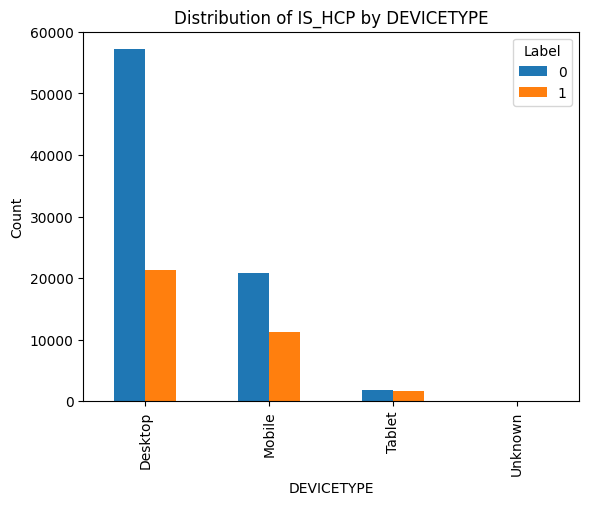

In [26]:
plot_categoricals(df,'DEVICETYPE')

IS_HCP           0.0      1.0
PLATFORM_ID                  
1               31.0      9.0
2            54939.0  24212.0
3                0.0    479.0
4              245.0    500.0
5             3014.0    216.0
6             2032.0    946.0
7            16758.0   4155.0
8               71.0     59.0
9             2453.0   1437.0
10             212.0    825.0
12               0.0    544.0
13               0.0     31.0
14               0.0    725.0
15               0.0     42.0
16               1.0      0.0


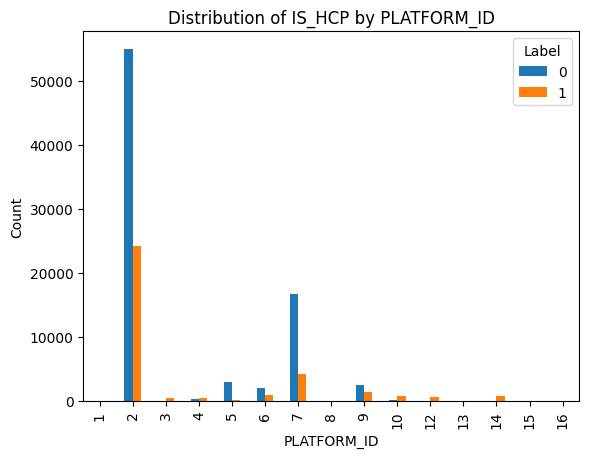

In [27]:
plot_categoricals(df,'PLATFORM_ID')

In [13]:
#plot_categoricals(df,'USERCITY')
#LOT OF VARIATIONS
#NOT MAKING ANY SENSE.
#REMOVE THE FEATURE USERCITY
drop_feature(df,'USERCITY')

df['CHANNELTYPE'].value_counts()
#all the values are "Website". It will not affect the model prediction in any way
#remove the column "CHANNELTYPE"
drop_feature(df,'CHANNELTYPE')


IS_HCP                        0.0      1.0
PLATFORMTYPE                              
Electronic Health Record     31.0      9.0
Medical News Platform         0.0    798.0
Online Learning Portal     2032.0    946.0
Online Medical Journal    77692.0  32427.0
Tele-medicine Platform        1.0      0.0


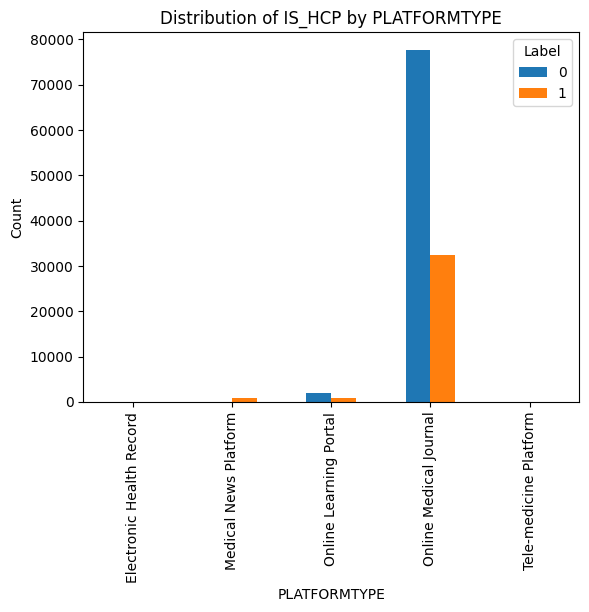

In [43]:
plot_categoricals(df,'PLATFORMTYPE')

# Graph level prediction

In [14]:
dataset = df[['KEYWORDS','IS_HCP']]

In [15]:
dataset.head()

,KEYWORDS,IS_HCP
0,General|Endocrine|False|Medicine|Surgery|Urolo...,0.0
1,Bone Marrow|Radiography|Chronic|Oncology|Psych...,0.0
2,General|Endocrine|False|Medicine|Surgery|Urolo...,0.0
3,Dental|Total|Clinical|Pharmacology|Physicians|...,1.0
4,Critical Care|Emergency Medicine|General Pract...,0.0


In [18]:
dataset = dataset.reset_index(drop=True)

In [19]:
''' the following list contains all the lis
t of key value pairs where keyworkd
contain the list of keywords and value is the IS_HCP '''
data = []

for i in range(len(dataset)):
    keywords = dataset['KEYWORDS'][i].split('|')
    label = dataset['IS_HCP'][i]

    data.append({
        "keyword" : keywords,
        "label" : label
    })


In [20]:
''' the following list contains all the lis
t of key value pairs where keyworkd
contain the list of keywords'''
new_data = []

for i in range(len(test_data)):
    keywords = test_data['KEYWORDS'][i].split('|')
    new_data.append({
        "keyword" : keywords,
    })

In [21]:
len(data), len(new_data)

(113936, 28493)

In [22]:
'''
the vocab_list is the list of all distinct keywords
'''
vocab = set()

for instance in data:
    keyword = instance["keyword"]
    vocab.update(keyword)

for instance in new_data:
    keyword = instance["keyword"]
    vocab.update(keyword)
vocab_list = list(vocab)

In [23]:
len(vocab_list)

1620

In [24]:
'''
The following code generates a one_hot_dict which stores the keyword
and the corresponding tensor
'''
import torch

keyword_to_index = {keyword: index for index, keyword in enumerate(vocab_list)}

one_hot_dict = {}

for keyword in vocab_list:
    one_hot_tensor = torch.zeros(len(vocab_list))
    keyword_index = keyword_to_index[keyword]
    one_hot_tensor[keyword_index] = 1
    one_hot_dict[keyword] = one_hot_tensor


In [25]:
'''
The following code creates a list of all the graph.
The `graphs` contains all the graph. Each graph is an instance
of the user.
The nodes of the graph are the keyword and the feature of the nodes are the tensors
The nodes are related to each other, hence an edge exist between them
'''
graphs = []

for instance in tqdm.tqdm(data, desc="creating graph"):
    graph = nx.Graph()

    keywords = instance['keyword']
    label = instance['label']

    for i, keyword in enumerate(keywords):
        one_hot_tensor = one_hot_dict[keyword]
        graph.add_node(i, features=one_hot_tensor)

    # Define the edges based on the indices of the keywords in the vocabulary list
    edges = list(itertools.combinations(range(len(keywords)), 2))

    graph.add_edges_from(edges)

    # Store the graph and label in the list
    graphs.append((graph, label))


creating graph: 100%|█████████████████| 113936/113936 [01:21<00:00, 1391.36it/s]


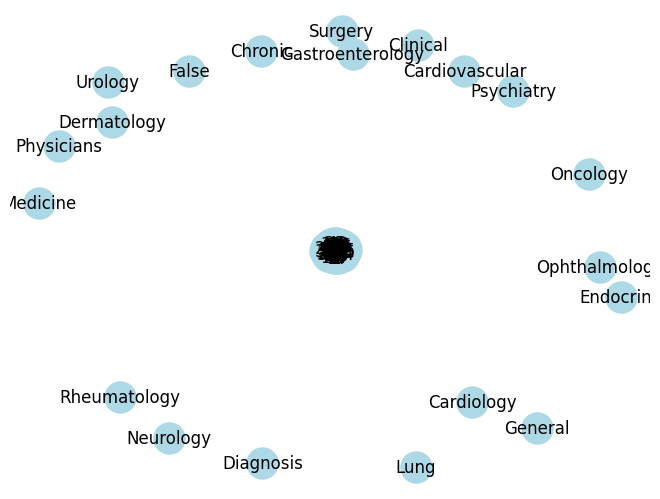

In [28]:
#visualization of the graph
temp_graph = nx.Graph()
keywords = data[0]['keyword']
label = data[0]['label']

for i,keyword in enumerate(keywords):
    temp_graph.add_node(keyword)
    edge = list(itertools.combinations(range(len(keywords)), 2))
    temp_graph.add_edges_from(edges)

pos = nx.spring_layout(temp_graph)
nx.draw(temp_graph, pos, with_labels=True, node_color='lightblue', node_size=500)
plt.show()


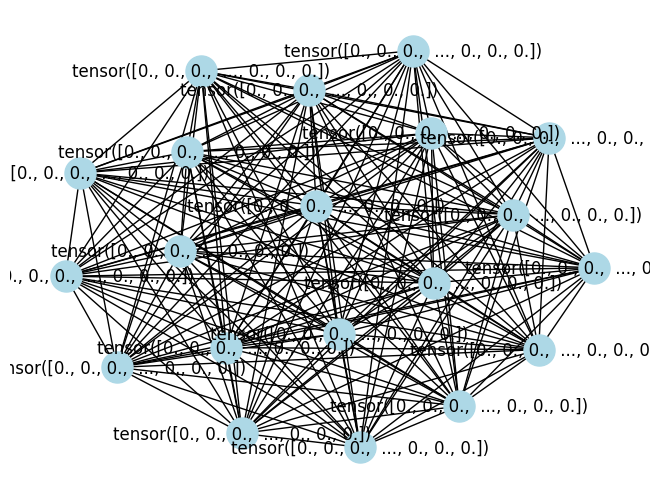

In [29]:
#visualise the graph created
graph, label = graphs[0]
node_features = nx.get_node_attributes(graph, 'features')
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=500, labels=node_features)
plt.show()


In [30]:
# Define the GNN model with GraphSAGE
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GNN, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(input_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # GraphSAGE layers
        for conv in self.convs:
            x = conv(x, edge_index)
            x = torch.relu(x)

        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

# Convert the graph dataset to PyG format
pyg_data_list = []
for graph, label in graphs:
    x = torch.stack([graph.nodes[node]['features'] for node in graph.nodes])
    edge_index = torch.tensor([list(edge) for edge in graph.edges]).t().contiguous()
    y = torch.tensor([label], dtype=torch.long)
    pyg_data_list.append(Data(x=x, edge_index=edge_index, y=y))

# Create data loader for batch processing
batch_size = 64
data_loader = DataLoader(pyg_data_list, batch_size=batch_size, shuffle=True)

# Initialize the GNN model
input_dim = len(vocab_list)
hidden_dim = 64
output_dim = 2  # Assuming binary classification (doctor vs. not doctor)
num_layers = 3  # Increase the number of layers
model = GNN(input_dim, hidden_dim, output_dim, num_layers)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for data in data_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

/home/sknt/miniconda3/envs/tf/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/10, Average Loss: 0.0847
Epoch 2/10, Average Loss: 0.0291
Epoch 3/10, Average Loss: 0.0216
Epoch 4/10, Average Loss: 0.0175
Epoch 5/10, Average Loss: 0.0152
Epoch 6/10, Average Loss: 0.0136
Epoch 7/10, Average Loss: 0.0121
Epoch 8/10, Average Loss: 0.0121
Epoch 9/10, Average Loss: 0.0106
Epoch 10/10, Average Loss: 0.0112


In [41]:
torch.save(model.state_dict(), 'graph_convolution_model.pt')

In [31]:
new_graphs = []
for instance in tqdm.tqdm(new_data):
    graph = nx.Graph()
    keywords = instance['keyword']
    for i, keyword in enumerate(keywords):
        if keyword in vocab_list:
            one_hot_tensor = one_hot_dict[keyword]
            graph.add_node(i, features=one_hot_tensor)
    edges = list(itertools.combinations(range(len(keywords)), 2))
    graph.add_edges_from(edges)
    new_graphs.append(graph)


100%|███████████████████████████████████| 28493/28493 [00:28<00:00, 1010.67it/s]


In [32]:
# Predict labels for the new data
model.eval()
predictions = []
for graph in tqdm.tqdm(new_graphs, desc="prediction"):

    # Convert the graph to PyG format
    node_indices = list(graph.nodes())
    x = torch.empty(len(node_indices), input_dim)  # Create an empty tensor for node features
    edge_index = torch.tensor(list(graph.edges)).t().contiguous()
    data = Data(x=x, edge_index=edge_index)

    # Assign the node features to the data tensor
    for i, node_index in enumerate(node_indices):
        x[i] = graph.nodes[node_index]['features']

    # Forward pass through the model
    with torch.no_grad():
        output = model(data)

    # Get the predicted label (assumes binary classification)
    predicted_label = torch.argmax(output).item()
    predictions.append(predicted_label)

prediction: 100%|████████████████████████| 28493/28493 [01:02<00:00, 458.99it/s]


In [34]:
test_sub = pd.read_csv('/home/sknt/Desktop/GNN-MILP_1/Aman_test/Doceree_Complete_DataSet-20230627T054239Z-001/Doceree_Complete_DataSet//Doceree-HCP_Test.csv')

In [35]:
test_sub = test_sub[['ID']]

In [36]:
predictions = pd.DataFrame(predictions, columns = ['IS_HCP'])

In [37]:
type(test_sub)

pandas.core.frame.DataFrame

In [38]:
final_submission = pd.concat([test_sub,predictions],axis=1)

In [39]:
final_submission

,ID,IS_HCP
0,115501,0
1,115502,1
2,115503,0
3,115504,0
4,115505,1
...,...,...
28488,143989,0
28489,143990,0
28490,143991,0
28491,143992,0


In [40]:
final_submission.to_csv('final_submission99.csv',index=False)